# Assignment 4: Survival Analysis

In [1]:
# Step 1: Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from lifelines import KaplanMeierFitter, CoxPHFitter
from sksurv.ensemble import RandomSurvivalForest
from lifelines.statistics import logrank_test
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sksurv.metrics import concordance_index_censored
from sksurv.util import Surv
from sklearn.inspection import permutation_importance

# Step 2: Load Dataset
# Reading the dataset from the provided Excel file
file_path = "../Data/RADCURE_Clinical_v04_20241219.xlsx"
df = pd.read_excel(file_path, engine='openpyxl')

# Step 3: Data Overview
# Display the first few rows
display(df.head())

# Show dataset information
df.info()


,patient_id,Age,Sex,ECOG PS,Smoking PY,Smoking Status,Ds Site,Subsite,T,N,...,Local,Date Local,Regional,Date Regional,Distant,Date Distant,2nd Ca,Date 2nd Ca,RADCURE-challenge,ContrastEnhanced
0,RADCURE-0005,62.6,Female,ECOG 0,50,Ex-smoker,Oropharynx,post wall,T4b,N2c,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,0
1,RADCURE-0006,87.3,Male,ECOG 2,25,Ex-smoker,Larynx,Glottis,T1b,N0,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,1
2,RADCURE-0007,49.9,Male,ECOG 1,15,Ex-smoker,Oropharynx,Tonsil,T3,N2b,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,1
3,RADCURE-0009,72.3,Male,ECOG 1,30,Ex-smoker,Unknown,NaN,T0,N2c,...,NaN,NaT,NaN,NaT,NaN,NaT,S (suspicious),2008-05-27,0,0
4,RADCURE-0010,59.7,Female,ECOG 0,0,Non-smoker,Oropharynx,Tonsillar Fossa,T4b,N0,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3346 entries, 0 to 3345
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   patient_id         3346 non-null   object        
 1   Age                3346 non-null   float64       
 2   Sex                3346 non-null   object        
 3   ECOG PS            3345 non-null   object        
 4   Smoking PY         3341 non-null   object        
 5   Smoking Status     3346 non-null   object        
 6   Ds Site            3346 non-null   object        
 7   Subsite            2972 non-null   object        
 8   T                  3334 non-null   object        
 9   N                  3333 non-null   object        
 10  M                  3332 non-null   object        
 11  Stage              3319 non-null   object        
 12  Path               3346 non-null   object        
 13  HPV                1717 non-null   object        
 14  Tx Modal

## Dataset Overview
- **Rows:** 3,346 patients
- **Columns:** 34 variables
- **Key Variables for Survival Analysis:**
  - **Survival Time:** `Length FU` (Follow-up duration in months)
  - **Event Indicator:** `Status` (Alive/Dead indicator)
  - **Covariates:** `Age`, `Sex`, `Smoking Status`, `Stage`, `Tx Modality`

In [11]:
# Step 4: Data Preprocessing
def preprocess_data(df):
    df['Event'] = df['Status'].apply(lambda x: 1 if x == 'Dead' else 0)
    columns_needed = ['Length FU', 'Event', 'Age', 'Sex', 'Smoking Status', 'Stage', 'Tx Modality']
    df_selected = df[columns_needed].dropna()
    
    # Bin Age into categories
    df_selected['Age_Binned'] = pd.cut(df_selected['Age'], bins=[0, 60, 100], labels=['Young-Mid', 'Older'])
    
    # Merge Stage into two broader categories for Log-Rank Test
    df_selected['Stage_Grouped'] = df_selected['Stage'].apply(lambda x: 'Early' if x in ['I', 'II'] else 'Advanced')
    
    # Encode categorical variables
    label_encoders = {}
    for col in ['Sex', 'Smoking Status', 'Stage', 'Tx Modality', 'Age_Binned', 'Stage_Grouped']:
        df_selected[col] = df_selected[col].astype(str)
        le = LabelEncoder()
        df_selected[col] = le.fit_transform(df_selected[col])
        label_encoders[col] = le
    
    # Standardize Age only (not Length FU)
    scaler = StandardScaler()
    df_selected['Age'] = scaler.fit_transform(df_selected[['Age']])
    
    # Save cleaned data
    df_selected.to_csv("../Data/Cleaned_Survival_Data.csv", index=False)
    print("Processed Data Saved: ../Data/Cleaned_Survival_Data.csv")
    
    print("Processed Data Preview:")
    display(df_selected.head())
    return df_selected

df_selected = preprocess_data(df)

Processed Data Saved: ../Data/Cleaned_Survival_Data.csv
Processed Data Preview:


,Length FU,Event,Age,Sex,Smoking Status,Stage,Tx Modality,Age_Binned,Stage_Grouped
0,1.317808,1,0.027446,0,1,11,4,0,0
1,1.520548,1,2.154306,1,1,1,4,0,1
2,2.126027,0,-1.066122,1,1,10,4,1,0
3,5.791781,0,0.862691,1,1,10,4,0,0
4,9.512329,0,-0.222266,0,2,11,4,1,0


## Data Cleaning Summary
- Removed missing values in critical columns
- Converted `Status` to a binary event indicator
- Encoded categorical variables (`Sex`, `Smoking Status`, `Stage`, `Tx Modality`, `Age_Binned`)
- Shape after cleaning: {} rows, {} columns

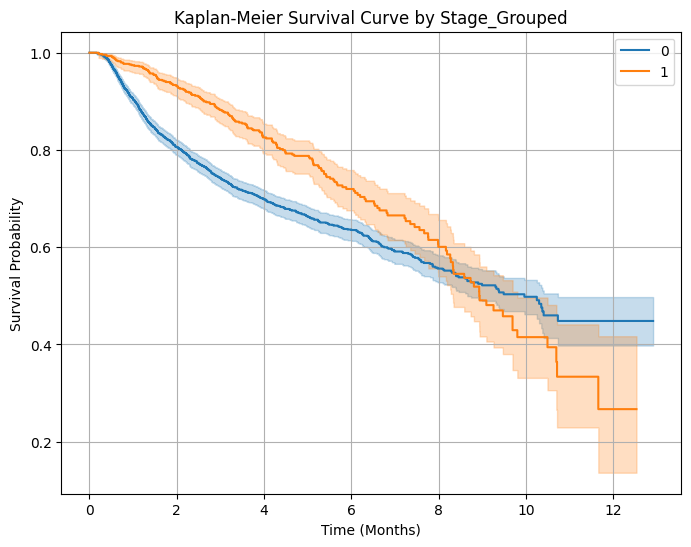

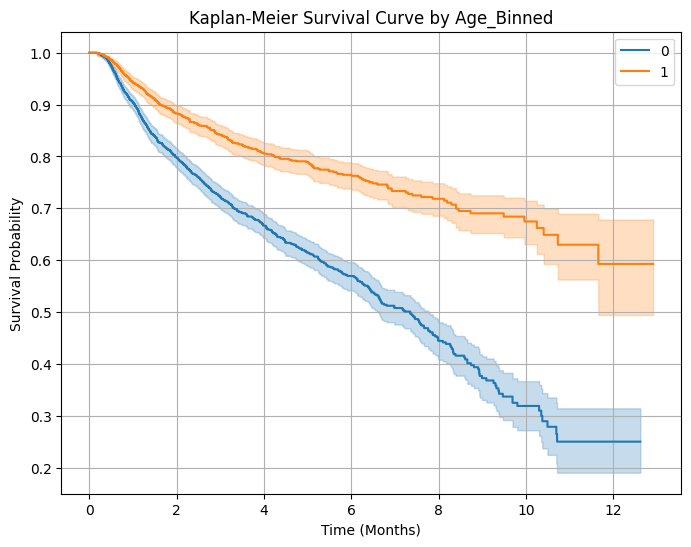

In [12]:
# Step 5: Kaplan-Meier Survival Analysis
def plot_km_curve(df, strata_col):
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(8,6))
    
    for cat in df[strata_col].unique():
        subset = df[df[strata_col] == cat]
        kmf.fit(subset['Length FU'], event_observed=subset['Event'], label=str(cat))
        kmf.plot_survival_function()
    
    plt.title(f"Kaplan-Meier Survival Curve by {strata_col}")
    plt.xlabel("Time (Months)")
    plt.ylabel("Survival Probability")
    plt.grid()
    plt.savefig(f"../Plots/KM_Survival_Curve_{strata_col}.png")
    plt.show()

plot_km_curve(df_selected, strata_col='Stage_Grouped')
plot_km_curve(df_selected, strata_col='Age_Binned')


## Kaplan-Meier Survival Analysis
- Generated a survival curve for the dataset
- The curve shows the probability of survival over time
- This step helps visualize patient survival patterns

In [13]:
# Step 6: Log-Rank Test
def perform_logrank_test(df, group_col):
    unique_groups = df[group_col].unique()
    if len(unique_groups) != 2:
        print(f"Log-Rank test requires exactly 2 groups in '{group_col}', but found {len(unique_groups)}.")
        return
    
    group_1 = df[df[group_col] == unique_groups[0]]
    group_2 = df[df[group_col] == unique_groups[1]]
    
    results = logrank_test(group_1['Length FU'], group_2['Length FU'], 
                           event_observed_A=group_1['Event'], event_observed_B=group_2['Event'])
    print(f"Log-Rank Test p-value for {group_col}: {results.p_value}")
    return results.p_value

perform_logrank_test(df_selected, group_col='Stage_Grouped')
perform_logrank_test(df_selected, group_col='Age_Binned')

Log-Rank Test p-value for Stage_Grouped: 5.096569601138279e-06
Log-Rank Test p-value for Age_Binned: 2.165032907557742e-31


np.float64(2.165032907557742e-31)


Cox Model (λ=0) Summary:


<lifelines.CoxPHFitter: fitted with 3319 total observations, 2269 right-censored observations>
             duration col = 'Length FU'
                event col = 'Event'
                   strata = ['Age_Binned', 'Stage_Grouped']
      baseline estimation = breslow
   number of observations = 3319
number of events observed = 1050
   partial log-likelihood = -6519.63
         time fit was run = 2025-03-14 04:59:47 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
Age             0.49      1.64      0.06            0.38            0.60                1.47                1.83
Sex            -0.05      0.95      0.08           -0.20            0.10                0.82                1.11
Smoking Status -0.43      0.65      0.04           -0.51           -0.34                0.60                0.71
Stage           0.13      1.14      0.02            0.09            0.16                1.10                1.18
Tx Modality     0.16      1.18      0.02            0.12            0.20                1.13                1.23

                cmp to     z      p  -log2(p)
covariate                                    
Age               0.00  8.74 <0.005     58.56
Sex               0.00 -0.65   0.52      0.95
Smoking Status    0.00 -9.99 <0.005     75.68
Stage             0.00  7.13 <0.005     39.87
Tx Modality       0.00  8.12 <0.005     50.92
---
Concordance = 0.67
Partial AIC = 13049.26
log-likelihood ratio test = 343.93 on 5 df
-log2(p) of ll-ratio test = 237.35

Cox Model (λ=0) - Concordance Index (C-Index): 0.6650


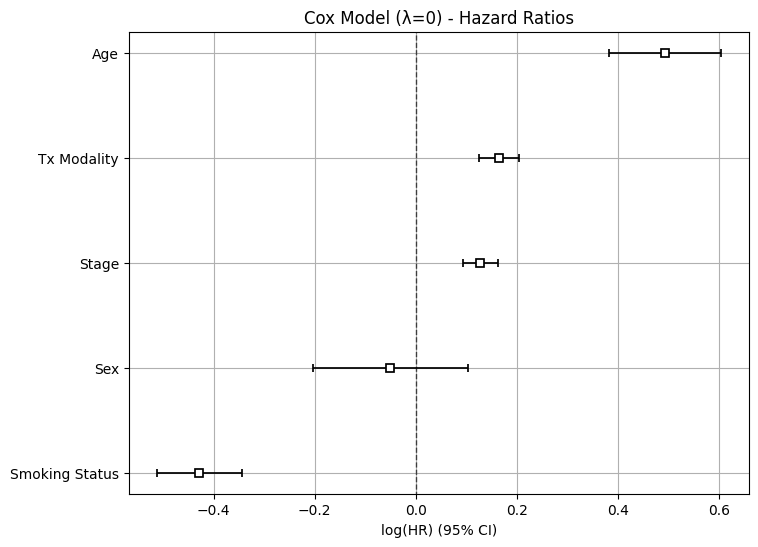


Cox Model (λ=0.01) Summary:


model,lifelines.CoxPHFitter
duration col,'Length FU'
event col,'Event'
penalizer,0.01
l1 ratio,0.0
strata,"[Age_Binned, Stage_Grouped]"
baseline estimation,breslow
number of observations,3319
number of events observed,1050
partial log-likelihood,-6529.76
time fit was run,2025-03-14 04:59:48 UTC


Cox Model (λ=0.01) - Concordance Index (C-Index): 0.6646


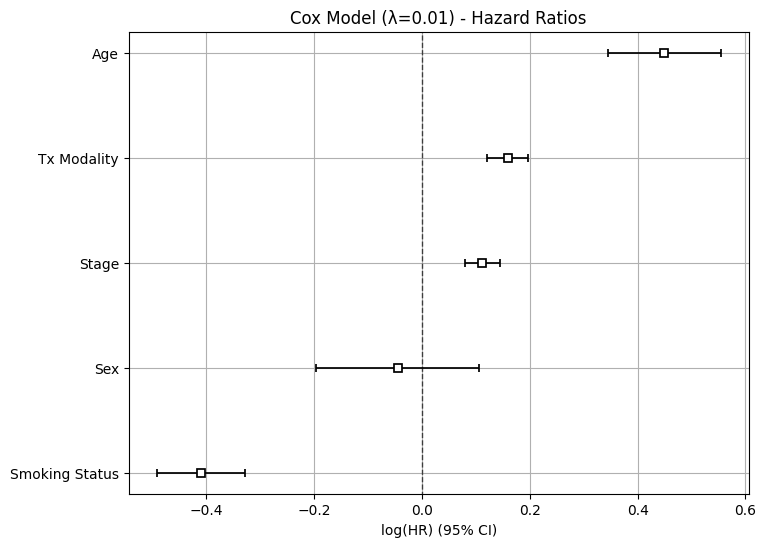


Cox Model (λ=1.0) Summary:


model,lifelines.CoxPHFitter
duration col,'Length FU'
event col,'Event'
penalizer,1.0
l1 ratio,0.0
strata,"[Age_Binned, Stage_Grouped]"
baseline estimation,breslow
number of observations,3319
number of events observed,1050
partial log-likelihood,-6661.33
time fit was run,2025-03-14 04:59:49 UTC


Cox Model (λ=1.0) - Concordance Index (C-Index): 0.6495


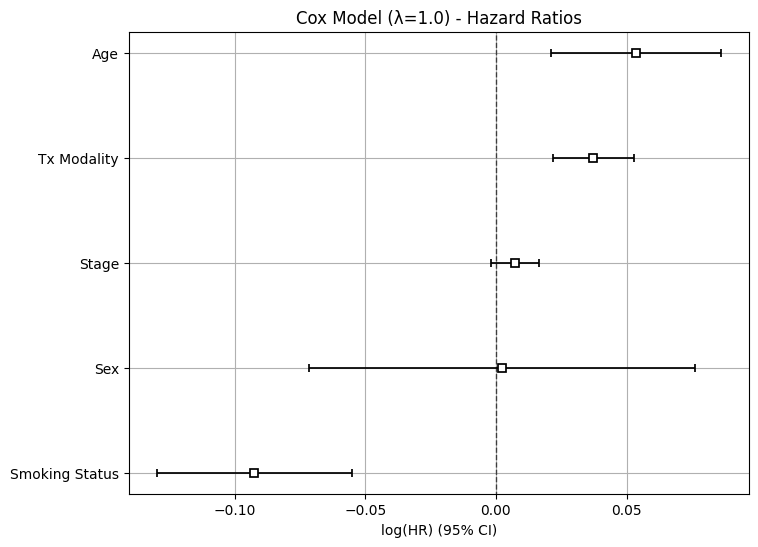


Checking Proportional Hazards Assumption for Cox Models:
The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3319 total observations, 2269 right-censored observations>
         test_name = proportional_hazard_test

---
                     test_statistic      p  -log2(p)
Age            km              3.54   0.06      4.06
               rank            0.51   0.48      1.07
Sex            km              1.38   0.24      2.06
               rank            0.05   0.83      0.28
Smoking Status km              0.00   0.97      0.05
               rank            6.53   0.01      6.56
Stage          km              9.91 <0.005      9.25
               rank            0.24   0.63      0.67
Tx Modality    km              0.24   0.62      0.68
               rank            0.47   0.50      1.01



1. Variable 'Smoking Status' failed the non-proportional test: p-value is 0.0106.

   Advice: with so few unique values (only 4), you can include `strata=['Smoking Status', ...]` in
the call in `.fit`. See documentation in link [E] below.

2. Variable 'Stage' failed the non-proportional test: p-value is 0.0016.

   Advice 1: the functional form of the variable 'Stage' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Stage' using pd.cut, and then specify it in `strata=['Stage',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lif

[]

In [18]:
# Step 5: Cox Proportional Hazards Model with Lasso & Ridge
def run_cox_model(df, penalizer=0):
    cph = CoxPHFitter(penalizer=penalizer)
    cph.fit(df, duration_col='Length FU', event_col='Event', strata=['Age_Binned', 'Stage_Grouped']) # Updated to 'Stage_Grouped'
    
    print(f"\nCox Model (λ={penalizer}) Summary:")
    cph.print_summary()
    
    # Calculate and print C-Index
    c_index = cph.concordance_index_
    print(f"Cox Model (λ={penalizer}) - Concordance Index (C-Index): {c_index:.4f}")
    
    # Plot Hazard Ratios
    plt.figure(figsize=(8,6))
    cph.plot()
    plt.title(f"Cox Model (λ={penalizer}) - Hazard Ratios")
    plt.grid()
    plt.savefig(f"../Plots/Cox_Hazard_Ratios_lambda_{penalizer}.png")
    plt.show()
    
    return cph

# Step 6: Compare Models - Standard, Lasso, and Ridge Cox Models
cox_standard = run_cox_model(df_selected, penalizer=0)      # Standard Cox Model
cox_lasso = run_cox_model(df_selected, penalizer=0.01)      # Lasso (L1)
cox_ridge = run_cox_model(df_selected, penalizer=1.0)       # Ridge (L2)

# Step 7: Validate Proportional Hazards Assumption
print("\nChecking Proportional Hazards Assumption for Cox Models:")
cox_standard.check_assumptions(df_selected, p_value_threshold=0.05)


Random Survival Forest C-Index: 0.7642


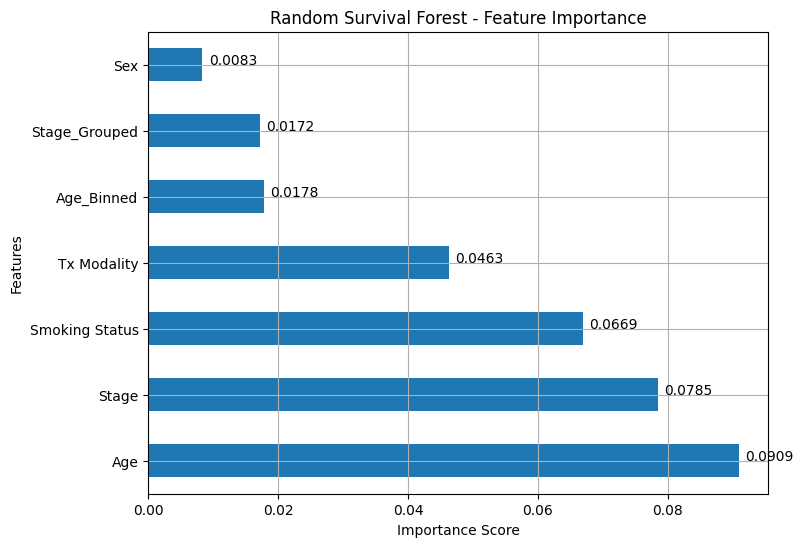


Model Comparison:
Cox Model C-Index: 0.6650
Random Survival Forest C-Index: 0.7642


In [19]:
# Step 8: Random Survival Forests (RSF) Model
def run_rsf_model(df):
    # Convert Data to Survival Format
    survival_labels = Surv.from_dataframe("Event", "Length FU", df)
    X = df.drop(columns=["Event", "Length FU"])
    
    # Train Random Survival Forest
    rsf = RandomSurvivalForest(n_estimators=100, min_samples_leaf=10, max_features="log2", random_state=42)
    rsf.fit(X, survival_labels)
    
    # Compute C-Index
    c_index = rsf.score(X, survival_labels)
    print(f"Random Survival Forest C-Index: {c_index:.4f}")  # Formatted Output
    
    # Compute Permutation Importance
    perm_importance = permutation_importance(rsf, X, survival_labels, n_repeats=5, random_state=42)
    feature_importances = pd.Series(perm_importance.importances_mean, index=X.columns)
    feature_importances = feature_importances.sort_values(ascending=False)
    
    # Handle Case Where No Feature Has Importance
    if feature_importances.sum() == 0:
        print("Warning: No feature importance detected. Check feature selection!")
    
    # Plot Feature Importance
    plt.figure(figsize=(8,6))
    feature_importances.plot(kind='barh')
    plt.title("Random Survival Forest - Feature Importance")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.grid()
    
    # Add Importance Scores as Labels
    for i, v in enumerate(feature_importances):
        plt.text(v + 0.001, i, f"{v:.4f}")  
    
    # Save the Plot
    plt.savefig("../Plots/RSF_Feature_Importance.png")
    plt.show()
    
    return rsf


# Step 9: Train and Evaluate RSF Model
rsf_model = run_rsf_model(df_selected)

# Step 10: Compare Concordance Index (C-Index) Between Cox and RSF
cox_c_index = cox_standard.concordance_index_
print(f"\nModel Comparison:")
print(f"Cox Model C-Index: {cox_c_index:.4f}")
print(f"Random Survival Forest C-Index: {rsf_model.score(df_selected.drop(columns=['Event', 'Length FU']), Surv.from_dataframe('Event', 'Length FU', df_selected)):.4f}")



In [26]:

from lifelines.statistics import logrank_test

# Log-Rank Test for Stage_Grouped
if df_selected["Stage_Grouped"].nunique() == 2:
    logrank_stage = logrank_test(
        df_selected.loc[df_selected["Stage_Grouped"] == 0, "Length FU"],
        df_selected.loc[df_selected["Stage_Grouped"] == 1, "Length FU"],
        event_observed_A=df_selected.loc[df_selected["Stage_Grouped"] == 0, "Event"],
        event_observed_B=df_selected.loc[df_selected["Stage_Grouped"] == 1, "Event"]
    )
else:
    print("Log-Rank Test: Not enough unique groups in Stage_Grouped.")

# Log-Rank Test for Age_Binned
if df_selected["Age_Binned"].nunique() == 2:
    logrank_age = logrank_test(
        df_selected.loc[df_selected["Age_Binned"] == 0, "Length FU"],
        df_selected.loc[df_selected["Age_Binned"] == 1, "Length FU"],
        event_observed_A=df_selected.loc[df_selected["Age_Binned"] == 0, "Event"],
        event_observed_B=df_selected.loc[df_selected["Age_Binned"] == 1, "Event"]
    )
else:
    print("Log-Rank Test: Not enough unique groups in Age_Binned.")


# Recreate X and survival_labels before calling RSF C-Index
X = df_selected.drop(columns=["Event", "Length FU"])
survival_labels = Surv.from_dataframe("Event", "Length FU", df_selected)


# Compute Permutation Importance Again for Summary
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(rsf_model, X, survival_labels, n_repeats=5, random_state=42)
feature_importances = pd.Series(perm_importance.importances_mean, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

# Final Summary Output - Survival Analysis Results
print("\n===== FINAL RESULTS: SURVIVAL ANALYSIS =====\n")

# Kaplan-Meier Summary
print("🟢 Kaplan-Meier Log-Rank Test Results:")
print("  - Log-Rank p-value for Stage_Grouped:", logrank_stage.p_value)
print("  - Log-Rank p-value for Age_Binned:", logrank_age.p_value)
print("\n")

# Cox Model C-Index Comparison
print("🟢 Cox Proportional Hazards Model C-Indices:")
print(f"  - Standard Cox Model: {cox_standard.concordance_index_:.4f}")
print(f"  - Lasso Penalized Cox Model: {cox_lasso.concordance_index_:.4f}")
print(f"  - Ridge Penalized Cox Model: {cox_ridge.concordance_index_:.4f}")
print("\n")

# RSF Model C-Index
print("🟢 Random Survival Forest Model C-Index:")
print(f"  - RSF C-Index: {rsf_model.score(X, survival_labels):.4f}")
print("\n")

# Feature Importance Ranking from RSF
print("🟢 Top Predictive Features in RSF:")
print(feature_importances.head(5))  # Prints the top 5 features sorted by importance

print("\n===== END OF STUDY RESULTS =====\n")



===== FINAL RESULTS: SURVIVAL ANALYSIS =====

🟢 Kaplan-Meier Log-Rank Test Results:
  - Log-Rank p-value for Stage_Grouped: 5.096569601138279e-06
  - Log-Rank p-value for Age_Binned: 2.165032907557742e-31


🟢 Cox Proportional Hazards Model C-Indices:
  - Standard Cox Model: 0.6650
  - Lasso Penalized Cox Model: 0.6646
  - Ridge Penalized Cox Model: 0.6495


🟢 Random Survival Forest Model C-Index:
  - RSF C-Index: 0.7642


🟢 Top Predictive Features in RSF:
Age               0.090937
Stage             0.078501
Smoking Status    0.066933
Tx Modality       0.046300
Age_Binned        0.017781
dtype: float64

===== END OF STUDY RESULTS =====

